In [1]:
import os 
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

import model_training

In [2]:
file = '../../data/data_model/data_sound_event_mel_buffer_stft100_22050_512_norm.pickle'
X, df_label = model_training.structure_data_for_modeling(file,classes=[0,1,2])
X = np.reshape(X, (*X.shape,1))
print(X.shape)

(95519, 47, 18, 1)


In [3]:
X_train,X_test,y_train,y_test,df_label = model_training.do_train_test_split_based_onsubject(X,df_label,n_subject=80,reshape_data=False)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(66577, 47, 18, 1) (66577,)
(28942, 47, 18, 1) (28942,)


In [4]:
X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])

0.697002690564181

In [5]:
df_label[df_label.train_test_split=='train'].label.value_counts()

0    35949
2    16275
1    14353
Name: label, dtype: int64

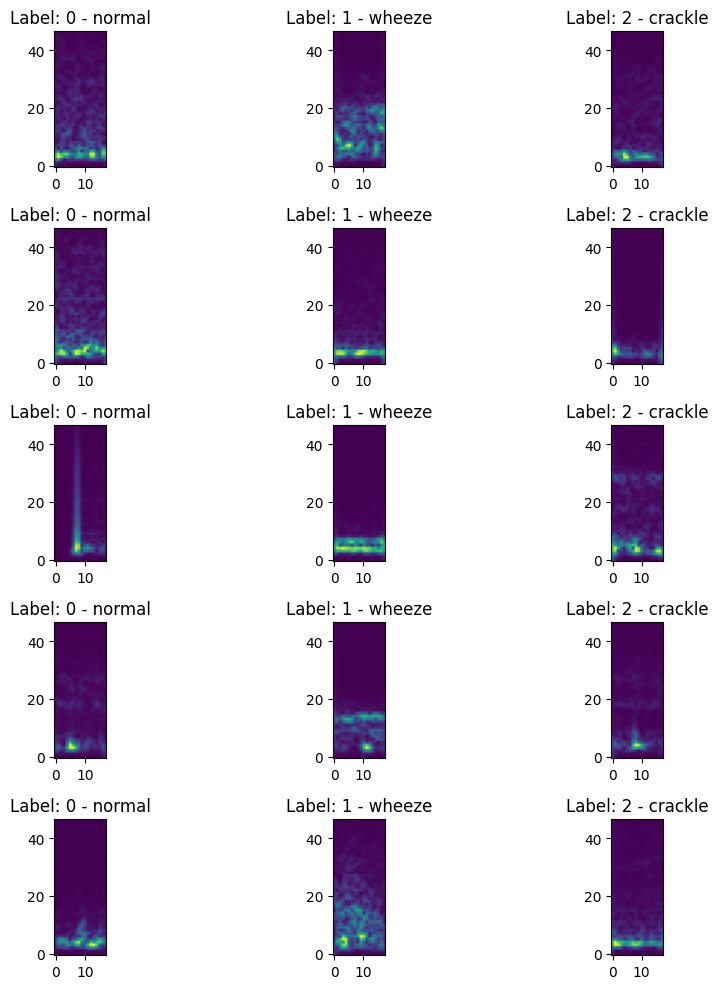

In [6]:
classes = {0:'normal',1:'wheeze',2:'crackle'}
f,axes = plt.subplots(5,3,figsize=(10,10))

for i in range(5):
    for class_,desc_ in classes.items():
        label_ = df_label[df_label.label==class_]
        index_classes_sample = label_.sample().index[0]
        axes[i,class_].imshow(X[index_classes_sample,:,:])
        axes[i,class_].invert_yaxis()
        axes[i,class_].set_title('Label: {} - {}'.format(class_, desc_))
f = plt.tight_layout()

<h1> Deep Learning Model<h1>

In [7]:
classes_weights = model_training.get_class_weight(y_train,return_dict=True)
print(classes_weights)
n_class = len(np.unique(y_train))
print('number of class identified: {}'.format(n_class))

{0: 1.5461808216632993, 1: 1.5461808216632993, 2: 1.5461808216632993}
number of class identified: 3


In [15]:

model = models.Sequential()

model.add(layers.Conv2D(64, [3,3],input_shape = X_train.shape[1:],activation='relu'))
model.add(layers.Conv2D(64, [3,3],activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(128, [3,3],activation='relu'))
model.add(layers.Conv2D(128, [3,3],activation='relu'))
model.add(layers.Conv2D(128, [3,3],padding='SAME',activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(n_class, activation = 'softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 45, 16, 64)        640       
                                                                 
 conv2d_34 (Conv2D)          (None, 43, 14, 64)        36928     
                                                                 
 dropout_14 (Dropout)        (None, 43, 14, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 21, 7, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 19, 5, 128)        73856     
                                                                 
 conv2d_36 (Conv2D)          (None, 17, 3, 128)        147584    
                                                      

In [16]:
opt = optimizers.Adam(lr=0.00001)
model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = opt,
    metrics=['accuracy'])

history = model.fit(X_train,
            y_train,
            batch_size=32,
            epochs=25,
            class_weight=classes_weights,
            validation_data=(X_test, y_test))

/Users/bastienorset/Documents/git/respiratory_sound/.venv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25


2022-11-11 16:27:43.980023: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2081/2081 [==============================] - 109s 52ms/step - loss: 1.5414 - accuracy: 0.5410 - val_loss: 1.0261 - val_accuracy: 0.5300
Epoch 2/25
2081/2081 [==============================] - 107s 52ms/step - loss: 1.4552 - accuracy: 0.5647 - val_loss: 0.9728 - val_accuracy: 0.6115
Epoch 3/25
2081/2081 [==============================] - 109s 52ms/step - loss: 1.3868 - accuracy: 0.5956 - val_loss: 0.9431 - val_accuracy: 0.6357
Epoch 4/25
2081/2081 [==============================] - 108s 52ms/step - loss: 1.3586 - accuracy: 0.6063 - val_loss: 0.9383 - val_accuracy: 0.6450
Epoch 5/25
2081/2081 [==============================] - 108s 52ms/step - loss: 1.3413 - accuracy: 0.6129 - val_loss: 0.9241 - val_accuracy: 0.6477
Epoch 6/25
2081/2081 [==============================] - 108s 52ms/step - loss: 1.3280 - accuracy: 0.6163 - val_loss: 0.9392 - val_accuracy: 0.5186
Epoch 7/25
2081/2081 [==============================] - 108s 52ms/step - loss: 1.3194 - accuracy: 0.6208 - val_loss: 0.9110 - val

Text(0.5, 1.0, 'Loss')

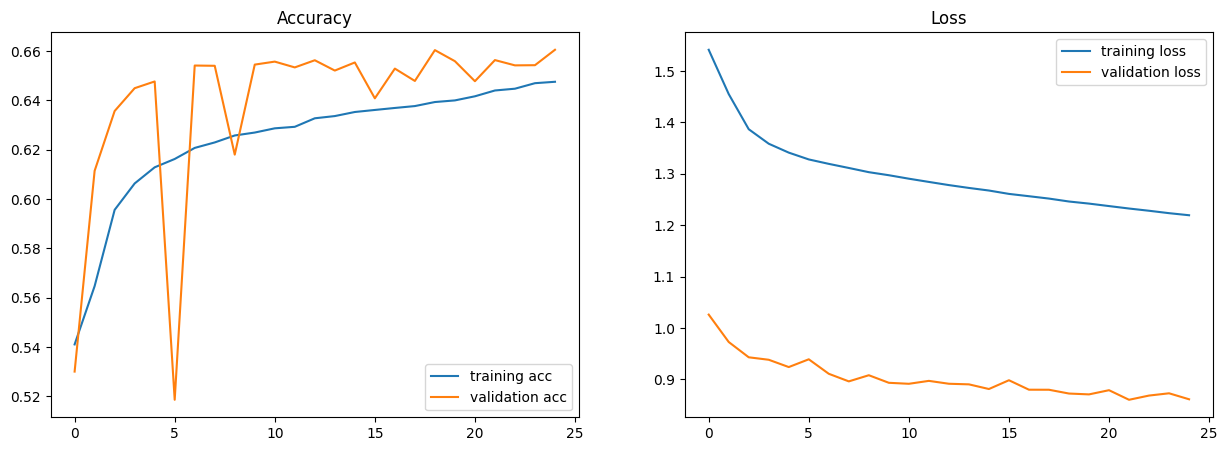

In [18]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()
#plt.ylim([0,1])
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')
#plt.ylim([0,1])

In [19]:
print("Evaluate model on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate model on test data
905/905 [==============================] - 22s 24ms/step - loss: 0.8614 - accuracy: 0.6606
test loss, test acc: [0.8613811135292053, 0.6605625152587891]


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict = model.predict(X_test)
y_predict = np.argmax(y_predict,axis=1)
confusion_matrix(y_test, y_predict)

905/905 [==============================] - 28s 31ms/step


array([[13307,   896,  1072],
       [ 4356,  4155,   459],
       [ 2934,   107,  1656]])

In [21]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74     15275
           1       0.81      0.46      0.59      8970
           2       0.52      0.35      0.42      4697

    accuracy                           0.66     28942
   macro avg       0.66      0.56      0.58     28942
weighted avg       0.67      0.66      0.64     28942



In [ ]:
cf_matrix = [[13307,896,1072],[4356,4155,459],[2934,107,1656]]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=".0f")
ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Wheeze','Crackle'])
ax.yaxis.set_ticklabels(['Normal','Wheeze','Crackle'])
cb = ax.colorbar() 
cb.remove() 